# Basic single trial fNIRS finger tapping classification  

This notebook sketches the analysis of a finger tapping dataset with multiple subjects. A simple Linear Discriminant Analysis (LDA) classifier is trained to distinguish left and right fingertapping.

In [7]:
import cedalion
import cedalion.nirs
from cedalion.datasets import get_multisubject_fingertapping_snirf_paths
import cedalion.sigproc.quality as quality
import cedalion.plots as plots
import numpy as np
import xarray as xr
import matplotlib.pyplot as p

from sklearn.preprocessing import LabelEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

xr.set_options(display_max_rows=3, display_values_threshold=50)
np.set_printoptions(precision=4)

### Loading raw CW-NIRS data from a SNIRF file

This notebook uses a finger-tapping dataset in BIDS layout provided by [Rob Luke](https://github.com/rob-luke/BIDS-NIRS-Tapping). It can can be downloaded via `cedalion.datasets`.

Cedalion's `read_snirf` method returns a list of `Recording` objects. These are containers for timeseries and adjunct data objects.

In [2]:
fnames = get_multisubject_fingertapping_snirf_paths()
subjects = [f"sub-{i:02d}" for i in [1, 2, 3, 4, 5]]

# store data of different subjects in a dictionary
data = {}
for subject, fname in zip(subjects, fnames):
    records = cedalion.io.read_snirf(fname)
    rec = records[0]
    display(rec)

    # Cedalion registers an accessor (attribute .cd ) on pandas DataFrames.
    # Use this to rename trial_types inplace.
    rec.stim.cd.rename_events(
        {"1.0": "control", "2.0": "Tapping/Left", "3.0": "Tapping/Right"}
    )

    dpf = xr.DataArray(
        [6, 6],
        dims="wavelength",
        coords={"wavelength": rec["amp"].wavelength},
    )

    rec["od"] = -np.log(rec["amp"] / rec["amp"].mean("time")),
    rec["conc"] = cedalion.nirs.beer_lambert(rec["amp"], rec.geo3d, dpf)

    data[subject] = rec

<Recording |  timeseries: ['amp'],  masks: [],  stim: ['1.0', '15.0', '2.0', '3.0'],  aux_ts: [],  aux_obj: []>

<Recording |  timeseries: ['amp'],  masks: [],  stim: ['1.0', '15.0', '2.0', '3.0'],  aux_ts: [],  aux_obj: []>

<Recording |  timeseries: ['amp'],  masks: [],  stim: ['1.0', '15.0', '2.0', '3.0'],  aux_ts: [],  aux_obj: []>

<Recording |  timeseries: ['amp'],  masks: [],  stim: ['1.0', '15.0', '2.0', '3.0'],  aux_ts: [],  aux_obj: []>

<Recording |  timeseries: ['amp'],  masks: [],  stim: ['1.0', '15.0', '2.0', '3.0'],  aux_ts: [],  aux_obj: []>

Illustrate the dataset of one subject

In [3]:
display(data["sub-01"])

<Recording |  timeseries: ['amp', 'od', 'conc'],  masks: [],  stim: ['control', '15.0', 'Tapping/Left', 'Tapping/Right'],  aux_ts: [],  aux_obj: []>

### Frequency filtering and splitting into epochs

In [4]:
for subject, rec in data.items():
    # cedalion registers the accessor .cd on DataArrays
    # to provide common functionality like frequency filters...
    rec["conc_freqfilt"] = rec["conc"].cd.freq_filter(
        fmin=0.01, fmax=0.5, butter_order=4
    )

    # ... or epoch splitting
    rec["cfepochs"] = rec["conc_freqfilt"].cd.to_epochs(
        rec.stim,  # stimulus dataframe
        ["Tapping/Left", "Tapping/Right"],  # select events
        before=5,  # seconds before stimulus
        after=20,  # seconds after stimulus
    )

### Plot frequency filtered data
Illustrate for a single subject and channel the effect of the bandpass filter.

In [ ]:
rec = data["sub-01"]
channel = "S5D7"

f, ax = p.subplots(2, 1, figsize=(12, 4), sharex=True)
ax[0].plot(rec["conc"].time, rec["conc"].sel(channel=channel, chromo="HbO"), "r-", label="HbO")
ax[0].plot(rec["conc"].time, rec["conc"].sel(channel=channel, chromo="HbR"), "b-", label="HbR")
ax[1].plot(
    rec["conc_freqfilt"].time,
    rec["conc_freqfilt"].sel(channel=channel, chromo="HbO"),
    "r-",
    label="HbO",
)
ax[1].plot(
    rec["conc_freqfilt"].time,
    rec["conc_freqfilt"].sel(channel=channel, chromo="HbR"),
    "b-",
    label="HbR",
)
ax[0].set_xlim(1000, 1100)
ax[1].set_xlabel("time / s")
ax[0].set_ylabel("$\Delta c$ / $\mu M$")
ax[1].set_ylabel("$\Delta c$ / $\mu M$")
ax[0].legend(loc="upper left")
ax[1].legend(loc="upper left");

### Baseline removal and Feature extraction

In [23]:
for subject, rec in data.items():
    # calculate baseline
    baseline_conc = rec["cfepochs"].sel(reltime=(rec["cfepochs"].reltime < 0)).mean("reltime")
    # subtract baseline
    rec["cfbl_epochs"] = rec["cfepochs"] - baseline_conc

In [24]:
display(data["sub-01"]["cfbl_epochs"])

<xarray.DataArray 'concentration' (epoch: 60, chromo: 2, channel: 28,
                                   reltime: 196)> Size: 5MB
<Quantity([[[[ 5.6399e-02  5.8440e-02  5.9971e-02 ...  8.4053e-02  5.7785e-02
     3.0591e-02]
   [ 6.5913e-02  6.6317e-02  6.6212e-02 ... -8.4743e-02 -9.1544e-02
    -9.6682e-02]
   [ 3.2711e-02  3.8240e-02  4.3175e-02 ... -7.6762e-02 -9.1897e-02
    -1.0714e-01]
   ...
   [ 4.5666e-02  5.2519e-02  5.8490e-02 ... -4.2794e-01 -4.4735e-01
    -4.6583e-01]
   [ 4.4105e-02  4.6513e-02  4.8774e-02 ... -6.4915e-01 -6.5702e-01
    -6.6409e-01]
   [ 4.9091e-02  5.0023e-02  5.2409e-02 ... -3.7885e-01 -3.9675e-01
    -4.1303e-01]]

  [[ 2.5081e-02  1.5802e-02  6.6139e-03 ... -1.9728e-01 -1.9464e-01
    -1.8887e-01]
   [ 5.1305e-03  8.1378e-03  1.1146e-02 ... -1.2852e-01 -1.3477e-01
    -1.3996e-01]
   [ 2.7624e-02  2.3426e-02  1.9616e-02 ... -2.0702e-01 -2.0602e-01
    -2.0372e-01]
...
   [ 1.4664e-01  1.5583e-01  1.6323e-01 ... -7.5917e-02 -6.9245e-02
    -6.2012e-02]
   [-4.9167e-01 -4.3497e-01 -3.7903e-01 ... -1.3262e+00 -1.3239e+00
    -1.3214e+00]
   [ 2.8546e-01  2.7940e-01  2.7309e-01 ... -2.1708e-01 -2.1742e-01
    -2.1840e-01]]

  [[ 4.3021e-02  3.5256e-02  2.6961e-02 ... -6.1753e-02 -6.1748e-02
    -6.2594e-02]
   [ 3.7140e-02  3.4811e-02  3.1369e-02 ... -9.4542e-02 -9.1955e-02
    -8.8309e-02]
   [ 8.7445e-03 -4.0919e-04 -7.9067e-03 ... -1.0616e-01 -1.0208e-01
    -9.7628e-02]
   ...
   [ 1.2832e-02  7.8763e-03  2.6368e-03 ... -1.0371e-01 -1.0252e-01
    -1.0218e-01]
   [-2.1209e-02 -1.2630e-02 -3.6352e-03 ... -3.1036e-01 -3.0263e-01
    -2.9583e-01]
   [ 6.9477e-02  6.4419e-02  5.8657e-02 ... -1.1099e-01 -1.0738e-01
    -1.0441e-01]]]], 'micromolar')>
Coordinates: (3/6)
  * chromo      (chromo) <U3 24B 'HbO' 'HbR'
  * channel     (channel) object 224B 'S1D1' 'S1D2' 'S1D3' ... 'S8D8' 'S8D16'
    ...          ...
    trial_type  (epoch) object 480B 'Tapping/Left' ... 'Tapping/Right'
Dimensions without coordinates: epoch

### Block Averages across all participants and trials per condition

In [25]:
# concatenate all epochs across subjects for the Block Grand Average
all_epochs = xr.concat([rec["cfbl_epochs"] for rec in data.values()], dim="epoch")

# group trials by trial_type. For each group individually average the epoch dimension
blockaverage = all_epochs.groupby("trial_type").mean("epoch")

Plotting averaged epochs

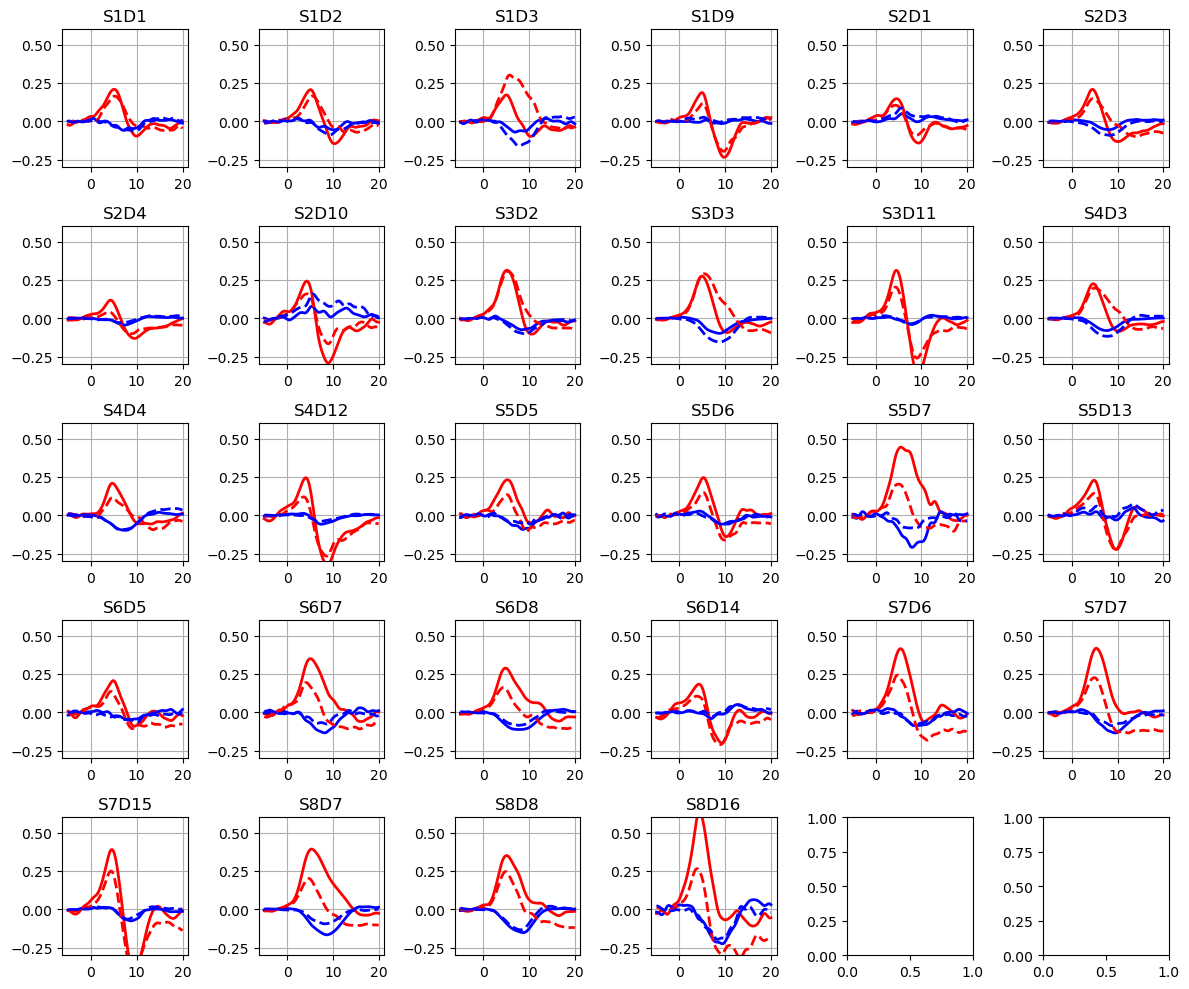

In [26]:
f, ax = p.subplots(5, 6, figsize=(12, 10))
ax = ax.flatten()
for i_ch, ch in enumerate(blockaverage.channel):
    for ls, trial_type in zip(["-", "--"], blockaverage.trial_type):
        ax[i_ch].plot(
            blockaverage.reltime,
            blockaverage.sel(chromo="HbO", trial_type=trial_type, channel=ch),
            "r",
            lw=2,
            ls=ls,
        )
        ax[i_ch].plot(
            blockaverage.reltime,
            blockaverage.sel(chromo="HbR", trial_type=trial_type, channel=ch),
            "b",
            lw=2,
            ls=ls,
        )
    ax[i_ch].grid(1)
    ax[i_ch].set_title(ch.values)
    ax[i_ch].set_ylim(-0.3, 0.6)

p.tight_layout()

## Training a LDA classifier with Scikit-Learn
### Feature Extraction
We use very simple min, max and avg features.

In [40]:
for subject, rec in data.items():

    # avg signal between 0 and 10 seconds after stimulus onset
    fmean = rec["cfbl_epochs"].sel(reltime=slice(0, 10)).mean("reltime")
    # min signal between 0 and 15 seconds after stimulus onset
    fmin = rec["cfbl_epochs"].sel(reltime=slice(0, 15)).min("reltime")
    # max signal between 0 and 15 seconds after stimulus onset
    fmax = rec["cfbl_epochs"].sel(reltime=slice(0, 15)).max("reltime")
      
    # concatenate features and stack them into a single dimension
    X = xr.concat([fmean, fmin, fmax], dim="reltime")
    X = X.stack(features=["chromo", "channel", "reltime"])

    # strip units. sklearn would strip them anyway and issue a warning about it.
    X = X.pint.dequantify()

    # need to manually tell xarray to create an index for trial_type
    X = X.set_xindex("trial_type")

    # save in recording container
    rec["X"] = X

In [41]:
display(data["sub-01"]["X"])

<xarray.DataArray 'concentration' (epoch: 60, features: 168)> Size: 81kB
array([[ 0.4978,  0.014 ,  0.8452, ..., -0.0024, -0.0886,  0.0689],
       [ 0.0383, -0.3366,  0.2726, ...,  0.0159, -0.0366,  0.0607],
       [ 0.11  , -0.0476,  0.3637, ...,  0.0177, -0.0571,  0.0675],
       ...,
       [ 0.1234, -0.1601,  0.3823, ..., -0.0497, -0.1051, -0.0201],
       [ 0.4953, -0.4348,  0.7727, ..., -0.0523, -0.4279,  0.5993],
       [ 0.0769, -0.3463,  0.4423, ..., -0.0646, -0.1659, -0.0157]])
Coordinates: (3/7)
    source      (features) object 1kB 'S1' 'S1' 'S1' 'S1' ... 'S8' 'S8' 'S8'
    detector    (features) object 1kB 'D1' 'D1' 'D1' 'D2' ... 'D16' 'D16' 'D16'
    ...          ...
  * reltime     (features) int64 1kB 0 1 2 0 1 2 0 1 2 0 ... 2 0 1 2 0 1 2 0 1 2
Dimensions without coordinates: epoch
Attributes:
    units:    micromolar

In [43]:
# Encode labels for use in scikit-learn
for subject, rec in data.items():
    rec["Y"] = xr.apply_ufunc(LabelEncoder().fit_transform, rec["X"].trial_type)

display(data["sub-01"]["Y"])  

<xarray.DataArray 'trial_type' (epoch: 60)> Size: 240B
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
Coordinates:
  * trial_type  (epoch) object 480B 'Tapping/Left' ... 'Tapping/Right'
Dimensions without coordinates: epoch

In [45]:
# train classifier for each subject
for subject, rec in data.items():
    # do a train-test split using 30%
    X_train, X_test, y_train, y_test = train_test_split(rec["X"],rec["Y"], test_size=0.3, stratify=rec["Y"])
    classifier = LinearDiscriminantAnalysis(n_components=1).fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    print(f"Accuracy subject {subject}: {accuracy_score(y_test, y_pred)}")

Accuracy subject sub-01: 0.6666666666666666
Accuracy subject sub-02: 0.7222222222222222
Accuracy subject sub-03: 0.6666666666666666
Accuracy subject sub-04: 1.0
Accuracy subject sub-05: 1.0


In [ ]:
f, ax = p.subplots(1, 2, figsize=(12, 3))
for trial_type, c in zip(["Tapping/Left", "Tapping/Right"], ["r", "g"]):
    kw = dict(alpha=0.5, fc=c, label=trial_type)
    ax[0].hist(classifier.decision_function(X_train.sel(trial_type=trial_type)), **kw)
    ax[1].hist(classifier.decision_function(X_test.sel(trial_type=trial_type)), **kw)

ax[0].set_xlabel("LDA score")
ax[1].set_xlabel("LDA score")
ax[0].set_title("train")
ax[1].set_title("test")
ax[0].legend(ncol=1, loc="upper left")
ax[1].legend(ncol=1, loc="upper left");